# Train a CNN

In this notebook we will go through all the steps required to train a fully convolutional neural network. Because this takes a while and uses a lot of GPU RAM a separate command line script (`train_nn.py`) is also provided in the `src` directory.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
from src.score import *
from collections import OrderedDict

In [3]:
tf.__version__

'2.1.0'

In [4]:
def limit_mem():
    """By default TF uses all available GPU memory. This function prevents this."""
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)

In [5]:
limit_mem()

In [6]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [7]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

## Create data generator

First up, we want to write our own Keras data generator. The key advantage to just feeding in numpy arrays is that we don't have to load the data twice because our intputs and outputs are the same data just offset by the lead time. Since the dataset is quite large and we might run out of CPU RAM this is important.

In [8]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])

In [9]:
z = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').drop('level')

In [10]:
# For the data generator all variables have to be merged into a single dataset.
datasets = [z, t]
ds = xr.merge(datasets)

In [11]:
# In this notebook let's only load a subset of the training data
ds_train = ds.sel(time=slice('1979', '2016'))  
ds_test = ds.sel(time=slice('2017', '2018'))

In [12]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [13]:
# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None, 't': None})

In [14]:
bs=32
lead_time=72

In [15]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM
Loading data into RAM


In [16]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)>
 array([54108.312  ,   274.52628], dtype=float32)
 Coordinates:
   * level    (level) int64 500 500,
 <xarray.DataArray 'z' (level: 2)>
 array([1114.979   ,    5.683259], dtype=float32)
 Coordinates:
   * level    (level) int64 500 500)

In [17]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


## Create and train model

Next up, we need to create the model architecture. Here we will use a fully connected convolutional network. Because the Earth is periodic in longitude, we want to use a periodic convolution in the lon-direction. This is not implemented in Keras, so we have to do it manually.

In [18]:
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

In [21]:
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)
        #x = BatchNormalization()(x)
        if dr > 0: x = Dropout(dr)(x, training = True)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)
    
cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 2), dr = 0.1)

In [22]:
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

In [23]:
cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 64, 2)]       0         
_________________________________________________________________
periodic_conv2d_10 (Periodic (None, 32, 64, 64)        3264      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 64, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 64, 64)        0         
_________________________________________________________________
periodic_conv2d_11 (Periodic (None, 32, 64, 64)        102464    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 64, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 64, 64)        0   

## Load predictions

In [24]:
#no batch normalisation

pred_ensemble = np.load('/rds/general/user/mc4117/home/WeatherBench/saved_pred/whole_no_bn_do_72.npy')

In [25]:
pred_ensemble.shape

(2, 17448, 32, 64, 20)

In [26]:
samples = 20
preds = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        pred_ensemble[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

In [27]:
preds

<xarray.Dataset>
Dimensions:  (ens: 20, lat: 32, lon: 64, time: 17448)
Coordinates:
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon, ens) float32 50686.188 50839.527 ... 49226.383
    t        (time, lat, lon, ens) float32 257.11508 257.21375 ... 249.90195

In [28]:
X1, y1 = dg_test[0]

for i in range(1, len(dg_test)):
    X2, y2 = dg_test[i]
    y1 = np.concatenate((y1, y2))  

In [29]:
real_unnorm =y1* dg_test.std.isel(level=[0,1]).values+dg_test.mean.isel(level=[0,1]).values

real_ds = xr.Dataset({
    'z': xr.DataArray(
        real_unnorm[..., 0],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        real_unnorm[..., 1],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

In [30]:
ens_rmse_list = []

ens = preds.isel(ens = 0).copy()

ens_rmse_list.append(compute_weighted_rmse(ens, real_ds).compute())

for i in range(1, samples):
    ens += preds.isel(ens = i).copy()
    ens_rmse_list.append(compute_weighted_rmse(ens/(i+1), real_ds).compute())

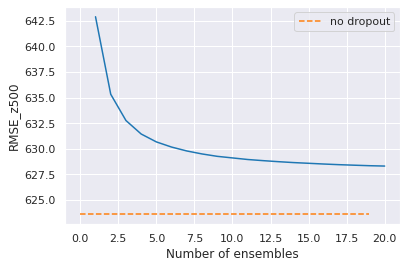

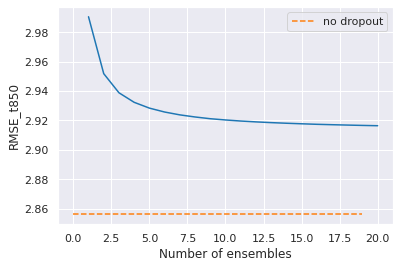

In [31]:
# effect of doing ensembles
plt.plot([i +1 for i in range(len(ens_rmse_list))], [ens_rmse_list[i].z for i in range(len(ens_rmse_list))])
plt.plot(np.arange(len(ens_rmse_list)), [623.6 for i in range(len(ens_rmse_list))], '--', label = 'no dropout')
plt.xlabel('Number of ensembles')
plt.ylabel('RMSE_z500')
plt.legend()
plt.show()

plt.plot([i +1 for i in range(len(ens_rmse_list))], [ens_rmse_list[i].t for i in range(len(ens_rmse_list))])
plt.plot(np.arange(len(ens_rmse_list)), [2.856 for i in range(len(ens_rmse_list))], '--', label = 'no dropout')
plt.xlabel('Number of ensembles')
plt.ylabel('RMSE_t850')
plt.legend()
plt.show()

In [32]:
ens_t = preds.t.isel(ens = 0)
ens_t2 = preds.t.isel(ens = 1)
ens_t_total = ens_t + ens_t2
for i in range(2, len(preds.ens)):
    ens_t_total = ens_t_total + preds.t.isel(ens = i)
    
ens_t_total = ens_t_total/(len(preds.ens))

ens_z = preds.z.isel(ens = 0)
ens_z2 = preds.z.isel(ens = 1)
ens_z_total = ens_z + ens_z2
for i in range(2, len(preds.ens)):
    ens_z_total = ens_z_total + preds.z.isel(ens = i)
    
ens_z_total = ens_z_total/(len(preds.ens))

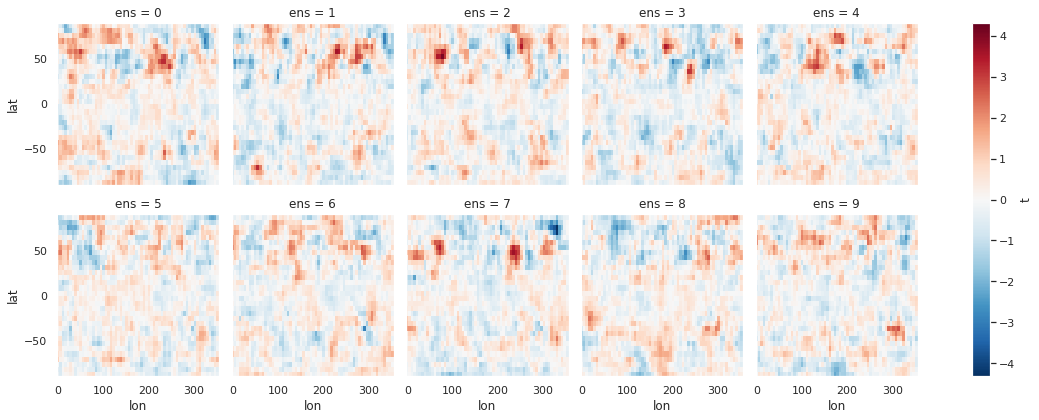

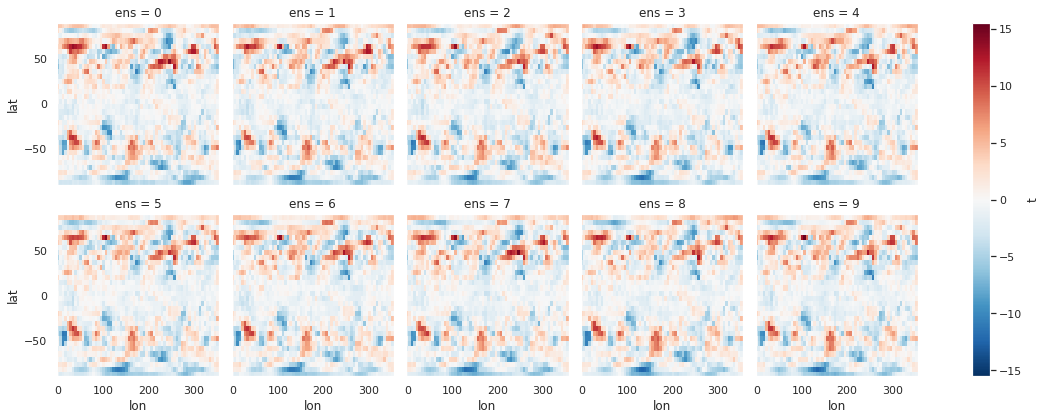

In [33]:
(preds.t.isel(time = 0) - ens_t_total.isel(time = 0)).isel(ens = slice(0,10)).plot(col='ens', col_wrap=5)
plt.show()
(preds.t.isel(time = 0) - real_ds.t.isel(time = 0)).isel(ens = slice(0, 10)).plot(col = 'ens', col_wrap = 5)
plt.show()

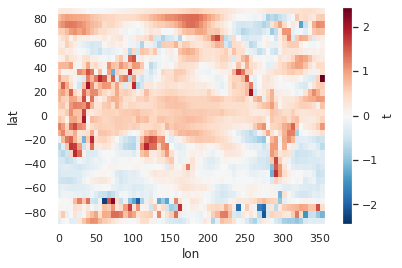

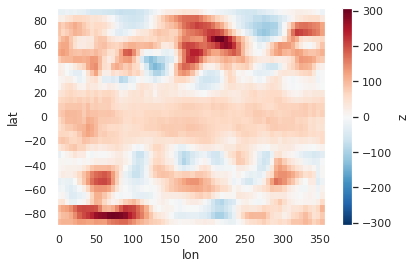

In [34]:
mean_ens_t = sum([real_ds.t.isel(time = i)-ens_t_total.isel(time = i) for i in range(len(real_ds.time))])/len(real_ds.time)
mean_ens_t.plot()
plt.show()
mean_ens_z = sum([real_ds.z.isel(time = i)-ens_z_total.isel(time = i) for i in range(len(real_ds.time))])/len(real_ds.time)
mean_ens_z.plot()
plt.show()

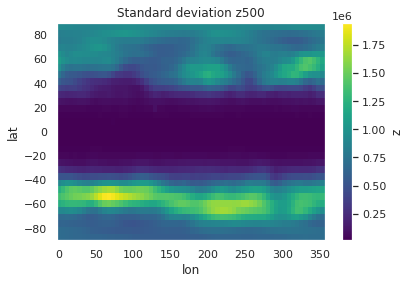

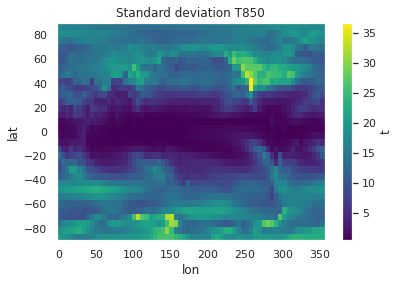

In [35]:
meansq_ens_z = sum([(real_ds.z.isel(time = i)-ens_z.isel(time = i))**2 for i in range(len(real_ds.time))])/len(real_ds.time)
(meansq_ens_z-mean_ens_z**2).plot()
plt.title('Standard deviation z500')
plt.show()
meansq_ens_t = sum([(real_ds.t.isel(time = i)-ens_t.isel(time = i))**2 for i in range(len(real_ds.time))])/len(real_ds.time)
(meansq_ens_t-mean_ens_t**2).plot()
plt.title('Standard deviation T850')
plt.show()